## RFM Analysis

In [58]:
import numpy as np
import pandas as pd
import time, warnings
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")

In [59]:
# Read the data
df=pd.read_excel("project data.xlsx", 'Sheet2')
df.head()

,CustomerID,TransactionID,PurchaseDate,Quantity,Unit price,Age,Gender,Region,ByCash,Color,ProductOnSale,ProductSeason,Reviews,Salary,Score
0,1074,C805767,2023-06-14,3,233,42,female,Asia,0,Purple,1.0,spring,"The comfort of Adidas shoes is unparalleled, m...",4963,5
1,1366,862164,NaT,2,159,56,female,Asia,1,Olive,1.0,fall,I had a terrible experience with Adidas custom...,486,1
2,1297,464780,2023-05-27,1,887,65,male,South America,0,Blue,0.0,spring,"The comfort of Adidas shoes is exceptional, pr...",517,4
3,1282,950352,2023-02-13,1,630,39,female,North America,0,mix,1.0,winter,Not completely satisfied with the quality of A...,1123,2
4,1868,144428,2022-12-23,2,684,43,female,Asia,0,Purple,1.0,spring,Adidas tracksuits not only look stylish but al...,458,5


In [60]:
#Get information about features we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerID     1003 non-null   int64         
 1   TransactionID  1003 non-null   object        
 2   PurchaseDate   1002 non-null   datetime64[ns]
 3   Quantity       1003 non-null   int64         
 4   Unit price     1003 non-null   int64         
 5   Age            1003 non-null   int64         
 6   Gender         1003 non-null   object        
 7   Region         1003 non-null   object        
 8   ByCash         1003 non-null   int64         
 9   Color          1003 non-null   object        
 10  ProductOnSale  1002 non-null   float64       
 11  ProductSeason  1003 non-null   object        
 12  Reviews        997 non-null    object        
 13  Salary         1003 non-null   int64         
 14  Score          1003 non-null   int64         
dtypes: datetime64[ns](1),

In [61]:
#Get statistical 
df.describe()

,CustomerID,PurchaseDate,Quantity,Unit price,Age,ByCash,ProductOnSale,Salary,Score
count,1003.000000,1002,1003.000000,1003.000000,1003.000000,1003.000000,1002.000000,1003.000000,1003.000000
mean,1637.563310,2023-05-26 11:09:42.035928064,1.796610,514.328016,42.266201,0.493519,0.501996,1780.569292,4.180459
min,1001.000000,2022-11-24 00:00:00,0.000000,0.000000,18.000000,0.000000,0.000000,400.000000,1.000000
25%,1321.000000,2023-02-27 06:00:00,1.000000,268.500000,31.000000,0.000000,0.000000,537.000000,4.000000
50%,1618.000000,2023-05-27 00:00:00,2.000000,518.000000,43.000000,0.000000,1.000000,955.000000,5.000000
75%,1952.500000,2023-08-25 00:00:00,2.000000,774.000000,53.000000,1.000000,1.000000,2924.000000,5.000000
max,2300.000000,2023-11-23 00:00:00,4.000000,1000.000000,65.000000,1.000000,1.000000,6781.000000,5.000000
std,373.115307,NaN,0.885968,288.031697,13.395859,0.500207,0.500246,1672.625966,1.323945


We can observe some extreme numbers within Quantity and UnitPrice. Also we have negative values for these variables. 
Quantity and UnitPrice need detailed examination.

In [62]:
#Find NAs for all variables
df.isnull().sum()

CustomerID       0
TransactionID    0
PurchaseDate     1
Quantity         0
Unit price       0
Age              0
Gender           0
Region           0
ByCash           0
Color            0
ProductOnSale    1
ProductSeason    0
Reviews          6
Salary           0
Score            0
dtype: int64

fig = px.box(df, x='UnitPrice')

fig.show()

fig = px.box(df, x='Quantity')

fig.show()

In [63]:
df = df[df['Quantity'] > 0 ] # exclude the orders with 0 value
df = df[df['Unit price'] > 0] # exclude the Unit Price with 0 value
df = df[~df['TransactionID'].str.contains("C",na=False)]  # C indicates the returned orders we don't want them as well

In [64]:
df.dropna(inplace=True)  # inplace=True means we dropped them permanently

In [65]:
#Create function to detect outliers based on quantiles
def define_boundaries(df, variable,q1=0.05,q2=0.95):# the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

#Create function to drop outliers
def drop_outliers(df,variable):
    upper_boundary,lower_boundary =  define_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [66]:
#Remove outliers
drop_outliers(df,'Unit price')
drop_outliers(df,'Quantity')

## **RFM** 

### (Recency, Frequency, Monetary) analysis first we need to create three features R , F & M from the data 

### Recency
##### To calculate recency, we need to find out, when was the customer's most recent purchase.

In [67]:
# Create a new column called date which contains the date of invoice only
df['date'] = pd.DatetimeIndex(df['PurchaseDate']).date

# Group by customers and check last date of purchase using max function
recency_df = df.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']

# Calculate recent date to find recency (maximum date in the dataset)
recent_date=recency_df.LastPurshaceDate.max()
print(recent_date)

# Calculate recency: maximum date from the dataset - maximum date for each customer
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (recent_date - x).days)
recency_df.head()

2023-11-23


,CustomerID,LastPurshaceDate,Recency
0,1001,2023-05-26,181
1,1003,2023-04-20,217
2,1005,2023-11-03,20
3,1006,2023-05-03,204
4,1007,2023-08-05,110


### Frequency
##### To calculate Frequency we need to check how often a customer makes a purchase

In [68]:
# Drop duplicates based on CustomerID and InvoiceNO columns. One order might include multiple invoices.
# Drop duplicates except for the first occurrence
df_new= df
df_new.drop_duplicates(subset=['TransactionID', 'CustomerID'], keep="first", inplace=True)

# Calculate the frequency of purchases
frequency_df = df_new.groupby(by=['CustomerID'], as_index=False)['TransactionID'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,1001,1
1,1003,2
2,1005,1
3,1006,1
4,1007,1


### Monetary
##### To calculate Monetary value how much money did the customer spent during the timeframe.

In [69]:
# Create column total cost
df['TotalCost'] = df['Quantity'] * df['Unit price']
monetary_df = df.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,1001,944.00
1,1003,2216.00
2,1005,662.00
3,1006,953.75
4,1007,206.00


#### Create a new table that contains RFM calculations

In [70]:
# Merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

# Merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')

rfm_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary
0,1001,2023-05-26,181,1,944.00
1,1003,2023-04-20,217,2,2216.00
2,1005,2023-11-03,20,1,662.00
3,1006,2023-05-03,204,1,953.75
4,1007,2023-08-05,110,1,206.00


### Rank customers by combining their individual R, F, and M rankings.

#### We are going to use Normalization method, that refers to rescaling real-valued numeric attributes into a 0 to 1 range.
#### Data normalization is used to make model training less sensitive to the scale of features. 
#### First, rank each score  then devide by the maxium of the scale

In [71]:
# Rank each metric R , F & M
rfm_df['R_rank'] = rfm_df['Recency'].rank( ascending=False) 
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
rfm_df.head()

# normalize each rank with Max rank
rfm_df['R_rank_norm']=(rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm']=(rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm']=(rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
0,1001,2023-05-26,181,1,944.00,272.0,233.0,449.0,39.534884,34.064327,33.866279
1,1003,2023-04-20,217,2,2216.00,212.0,544.0,551.0,30.813953,79.532164,79.069767
2,1005,2023-11-03,20,1,662.00,627.5,233.0,309.0,91.206395,34.064327,33.866279
3,1006,2023-05-03,204,1,953.75,229.0,233.0,465.5,33.284884,34.064327,33.866279
4,1007,2023-08-05,110,1,206.00,413.0,233.0,94.0,60.029070,34.064327,33.866279


### Based on the importance of your RFM scores, you can assign different weights to them
#### Let's say we are more interested in Monetary, so weight M 0.5, R and F 0.25 each

### RFM-Score = 0.25*R_rank_norm + 0.25*F_rank_norm + 0.5M_rank_norm

In [72]:
# Calculate RFM score
rfm_df['RFM_Score']=0.25*rfm_df['R_rank_norm']+0.25*rfm_df['F_rank_norm']+0.5*rfm_df['M_rank_norm']
rfm_df=rfm_df.round(0)
rfm_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,1001,2023-05-26,181,1,944.0,272.0,233.0,449.0,40.0,34.0,34.0,35.0
1,1003,2023-04-20,217,2,2216.0,212.0,544.0,551.0,31.0,80.0,79.0,67.0
2,1005,2023-11-03,20,1,662.0,628.0,233.0,309.0,91.0,34.0,34.0,48.0
3,1006,2023-05-03,204,1,954.0,229.0,233.0,466.0,33.0,34.0,34.0,34.0
4,1007,2023-08-05,110,1,206.0,413.0,233.0,94.0,60.0,34.0,34.0,40.0


### Segment customers based on their RFM score

In [73]:
# 0 - 50 - Risky customers
# 50 - 75 - Potential Loyalists
# 76 - 100 - Champions
rfm_df["Customer_segment"]=np.where(rfm_df['RFM_Score'] > 75 ,"Champions",(np.where(rfm_df['RFM_Score'] < 50 , "Risky Customers" ,"Potential Loyalists")))
rfm_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,1001,2023-05-26,181,1,944.0,272.0,233.0,449.0,40.0,34.0,34.0,35.0,Risky Customers
1,1003,2023-04-20,217,2,2216.0,212.0,544.0,551.0,31.0,80.0,79.0,67.0,Potential Loyalists
2,1005,2023-11-03,20,1,662.0,628.0,233.0,309.0,91.0,34.0,34.0,48.0,Risky Customers
3,1006,2023-05-03,204,1,954.0,229.0,233.0,466.0,33.0,34.0,34.0,34.0,Risky Customers
4,1007,2023-08-05,110,1,206.0,413.0,233.0,94.0,60.0,34.0,34.0,40.0,Risky Customers


In [74]:
champions = rfm_df[rfm_df['Customer_segment'] == 'Champions']
champions

merged_df = pd.merge(champions, df, on='CustomerID')
merged_df.to_csv('Champion customers data.csv', index=False)

In [75]:
at_risk = rfm_df[rfm_df['Customer_segment'] == 'Risky Customers']
at_risk

merged_df = pd.merge(at_risk, df, on='CustomerID')
merged_df.to_csv('At risk customers data.csv', index=False)

In [76]:
loyalist = rfm_df[rfm_df['Customer_segment'] == 'Potential Loyalists']
loyalist

merged_df = pd.merge(loyalist, df, on='CustomerID')
merged_df.to_csv('Potential loyalist customers data.csv', index=False)

In [77]:
rfm_df.groupby('Customer_segment')[['CustomerID']].count()

,CustomerID
Customer_segment,
Champions,140
Potential Loyalists,97
Risky Customers,451


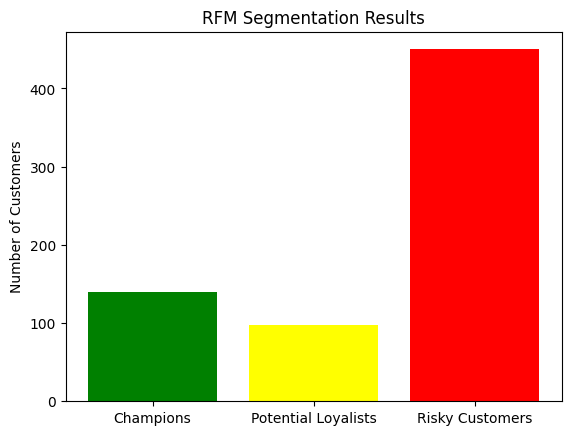

In [78]:
import matplotlib.pyplot as plt

rfm_results = {
    'Champions': 140,
    'Potential Loyalists': 98,
    'Risky Customers': 450
}

# Extracting labels and values
labels = list(rfm_results.keys())
values = list(rfm_results.values())

plt.bar(labels, values, color=['green', 'yellow', 'red'])

# Adding labels and title
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.title('RFM Segmentation Results')

plt.savefig('rfm_chart.png')

plt.show()

# Predict new customer group using KNN

In [79]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [80]:
#Create new dataset containing Recency, Frequency, Monetary values and Customer segment
knn_x_df = rfm_df[["Recency",'Frequency','Monetary']]
knn_y_df = rfm_df['Customer_segment']
knn_x_df.head()

,Recency,Frequency,Monetary
0,181,1,944.0
1,217,2,2216.0
2,20,1,662.0
3,204,1,954.0
4,110,1,206.0


##### Create dataset with normalized metrics, and see how the accuracy can be changed
knn_x_df = rfm_df[["R_rank_norm",'F_rank_norm','M_rank_norm']]

In [81]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(knn_x_df, knn_y_df, test_size=0.2, random_state=42)

In [82]:
best_k = 0
best_accuracy = 0

# will try different number of neighborus (Ks)
for k in range(2, 11):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')

    # compare current with the best 
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f'\nBest Model: k={best_k}, Accuracy: {best_accuracy * 100:.2f}%')

#  the best model
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
best_knn.fit(X_train, y_train)
best_y_pred = best_knn.predict(X_test)
best_accuracy = accuracy_score(y_test, best_y_pred)
print(f'Accuracy of the Best Model: {best_accuracy * 100:.2f}%')

Accuracy for k=2: 88.41%
Accuracy for k=3: 96.38%
Accuracy for k=4: 94.20%
Accuracy for k=5: 94.93%
Accuracy for k=6: 94.20%
Accuracy for k=7: 94.20%
Accuracy for k=8: 92.75%
Accuracy for k=9: 93.48%
Accuracy for k=10: 92.75%

Best Model: k=3, Accuracy: 96.38%
Accuracy of the Best Model: 96.38%


In [83]:
# Example: Make a prediction for a new customer
num_rows = 1000
random_recency = np.random.randint(rfm_df['Recency'].min(), rfm_df['Recency'].max() + 1, size=num_rows)
random_frequency = np.random.randint(rfm_df['Frequency'].min(), rfm_df['Frequency'].max() + 1, size=num_rows)
random_monetary = np.random.uniform(rfm_df['Monetary'].min(), rfm_df['Monetary'].max(), size=num_rows)

random_data = pd.DataFrame({
    'Recency': random_recency,
    'Frequency': random_frequency,
    'Monetary': random_monetary
})

random_data.head()

def get_segment_name(row):
    new_data_point = np.array([row[['Recency', 'Frequency', 'Monetary']]])
    prediction = knn.predict(new_data_point)
    return prediction[0]

random_data['Segment'] = random_data.apply(get_segment_name, axis=1)


In [84]:
random_data['Segment'].value_counts()

Segment
Champions              678
Potential Loyalists    185
Risky Customers        137
Name: count, dtype: int64

## KPI1: (Number of Champions / Number at Risk) VS (Champion Monetary Mean / At Risk Monetary Mean)

In [85]:
c_len = champions['CustomerID'].nunique()
r_len = at_risk['CustomerID'].nunique()

print(f'Number of champions: {c_len}')
print(f'Number of at risks: {r_len}')

Number of champions: 140
Number of at risks: 451


In [86]:
c_mean = champions['Monetary'].mean().round()
r_mean = at_risk['Monetary'].mean().round()

print(f'Monetary mean of champions: {c_mean}')
print(f'Monetary mean of at risks: {r_mean}')

Monetary mean of champions: 3449.0
Monetary mean of at risks: 510.0


In [87]:
ratio1 = c_len/r_len
ratio2 = c_mean/r_mean

print(f'(Number of Champions / Number at Risk): {ratio1}')
print(f'(Champion Monetary Mean / At Risk Monetary Mean): {ratio2}')

(Number of Champions / Number at Risk): 0.31042128603104213
(Champion Monetary Mean / At Risk Monetary Mean): 6.762745098039216


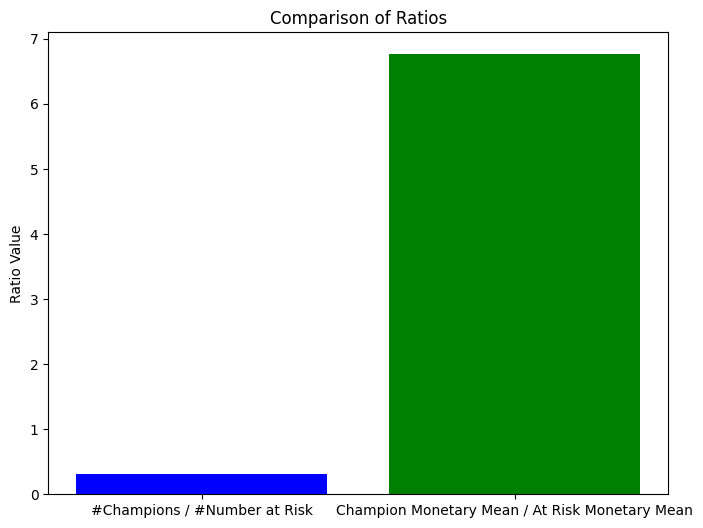

In [88]:
labels = ['#Champions / #Number at Risk', 'Champion Monetary Mean / At Risk Monetary Mean']

values = [ratio1, ratio2]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Comparison of Ratios')
plt.ylabel('Ratio Value')

plt.savefig('ratios_chart.png')

plt.show()
